In [1]:
# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time

pybullet build time: Aug  4 2022 15:57:56


In [2]:

# Let's use urdfpy to examine our urdf file before importing into pybullet
from urdfpy import URDF
## Instantiate the GUI and load the ground and robot URDF files
# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = p.connect(p.GUI) # or p.GUI

### This line is important if you are editing your URDF since it default caches them
p.setPhysicsEngineParameter(enableFileCaching=0) 

p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
# p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)
p.configureDebugVisualizer(p.COV_ENABLE_WIREFRAME,1)
p.configureDebugVisualizer(p.COV_ENABLE_KEYBOARD_SHORTCUTS,1)

/Users/rachitchhabra/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Version = 4.1 Metal - 83
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


In [3]:
# Use this to reset and retry
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file

# Load the URDF of the plane that forms the ground
plane = p.loadURDF("plane.urdf")

p.changeVisualShape(plane, -1, rgbaColor=[0.3, 1, 1, 0.5])

# Load the URDF of the robot
cubeStartPos = [0,0,2]
cubeStartOrientation = p.getQuaternionFromEuler([0,0,0])
hpr = p.loadURDF("monkey_model.urdf", cubeStartPos, cubeStartOrientation)

# Set the Gravity vector
p.setGravity(0,0,-9.81, physicsClientId = client)


In [4]:
# Set the simulation time-step. Default is 1/240
# p.setTimeStep(0.001) #The lower this is, more accurate the simulation 
## Build list of joints
numBodies = p.getNumBodies()
bodyNames = [p.getBodyInfo(ii) for ii in range(numBodies)]

print(f"Number of bodies: {numBodies}")
[print(name[1]) for name in bodyNames]

numJointsHopper = p.getNumJoints(hpr)
jointInfo = [p.getJointInfo(hpr, ii) for ii in range(numJointsHopper)]

## Make a dict of the joint names to easily access them for control purposes
joints = {str(joint[1])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Joint names:")
[print(key) for key, value in joints.items()];

# Link names are stored in the joint
links = {str(joint[12])[2:-1]: i for i, joint in enumerate(jointInfo)}

print("\r\n")
print(f"Link names:")
[print(key) for key, value in links.items()];

Number of bodies: 2
b'plane'
b'double_pendulum'


Joint names:
shoulder
elbow


Link names:
armLR
armUR


In [5]:
# Calculate Moment of Inertia for a cuboid

def calculate_box_inertia(m, w, d, h):
    Ixx = (m/12.0)*(pow(d,2)+pow(h,2))
    Iyy = (m / 12.0) * (pow(w, 2) + pow(h, 2))
    Izz = (m / 12.0) * (pow(w, 2) + pow(d, 2))
    return Ixx, Iyy, Izz
m = 1
w = 0.05
d = 0.05
h = 0.61
Ixx, Iyy, Izz = calculate_box_inertia(m, w, d, h)
Ixy = 0; Iyz = 0; Ixz = 0;
Ixx, Iyy, Izz, Ixy, Iyz, Ixz

(0.021041666666666667, 0.021041666666666667, 0.00041666666666666675, 0, 0, 0)

array([-0.78, -1.62])

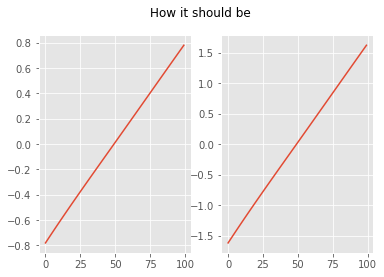

In [6]:
from scipy.interpolate import interp1d
keypoints = []
keypoints.append(np.array([-0.78,-1.62]))
keypoints.append(np.array([-0.39,-0.81]))
keypoints.append(np.array([0,0]))
keypoints.append(np.array([0.39,0.81]))
keypoints.append(np.array([0.78,1.62]))
keypoints = np.transpose(np.array(keypoints))

t = 100
times = np.linspace(1,t,t)
t_arr = np.array([1,t//4,2*t//4,3*t//4,t])
points = np.zeros((2,t))

for i in range(keypoints.shape[0]):
    points[i] = interp1d(t_arr, keypoints[i], kind = 'cubic')(times)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('How it should be')
ax1.plot(points[0,:])
ax2.plot(points[1,:])
points[:,0]

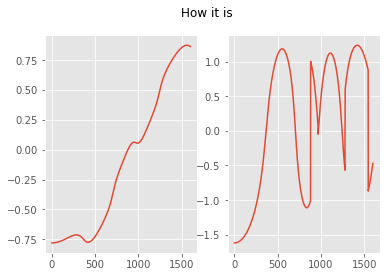

In [14]:
theta1 = np.load("theta1.npy")[0:1600]
theta2 = np.load("theta2.npy")[0:1600]
t1 = []
t2 = []
for i in range(theta1.shape[0]):
    if ((theta1[i]>0)&(theta2[i]>0)):
        t1.append(- theta1[i])
        t2.append(theta1[i] - theta2[i])

    elif ((theta1[i]<0)&(theta2[i]<0)):
        t1.append(- theta1[i])
        t2.append(theta1[i] - theta2[i])

    elif ((theta1[i]<0)&(theta2[i]>0)):
        t1.append(- theta1[i])
        t2.append(-theta1[i] + theta2[i])

    elif ((theta1[i]>0)&(theta2[i]<0)):
        t1.append(- theta1[i])
        t2.append(theta1[i] - theta2[i])
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('How it is')
ax1.plot(t1)
ax2.plot(t2)
t1 = t1[0::50]
t2 = t2[0::50]

In [24]:
p.setJointMotorControlArray(hpr, range(2), p.POSITION_CONTROL , targetPositions = [t1[0],t2[0]])
for i in range(100):
    p.stepSimulation()
    time.sleep(1/240.)
t = int(len(t1))
for i in range(t):
    p.setJointMotorControlArray(hpr, range(2), p.POSITION_CONTROL , targetPositions = [t1[i],t2[i]])
    p.stepSimulation()
    time.sleep(1/240.)
    for i in range(1):
        p.stepSimulation()
        time.sleep(1/960.)

p.setJointMotorControlArray(hpr, range(2), p.POSITION_CONTROL , targetPositions = [t1[-1],t2[-1]])
for i in range(50):
    p.stepSimulation()
    time.sleep(1/240.)


In [ ]:
p.setJointMotorControlArray(hpr, range(2), p.POSITION_CONTROL , targetPositions = [points[0,0],points[1,0]])
for i in range(50):
    p.stepSimulation()
    time.sleep(1/240.)

for i in range(t):
    p.setJointMotorControlArray(hpr, range(2), p.POSITION_CONTROL , targetPositions = [points[0,i],points[1,i]])
    p.stepSimulation()
    time.sleep(1/240.)

p.setJointMotorControlArray(hpr, range(2), p.POSITION_CONTROL , targetPositions = [points[0,-1],points[1,-1]])
# for i in range(50):
while True:
    p.stepSimulation()
    time.sleep(1/240.)

KeyboardInterrupt: 